# Recursive forecasting example

In this notebook we will show how to use trend features in a recursive forecasting workflow where we also have features built from the target (e.g., lag & window features).

In [1]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

sns.set_context("talk")

# Data set synopsis

The air passengers dataset is the monthly totals of international airline passengers, from 1949 to 1960, in units of 1000s. 

For instructions on how to download, prepare, and store the dataset, refer to notebook number 5, in the folder "01-Create-Datasets" from this repo.

In [2]:
data = pd.read_csv(
    "../Datasets/example_air_passengers.csv",
    parse_dates=["ds"],
    index_col=["ds"],
)

## Plot the data

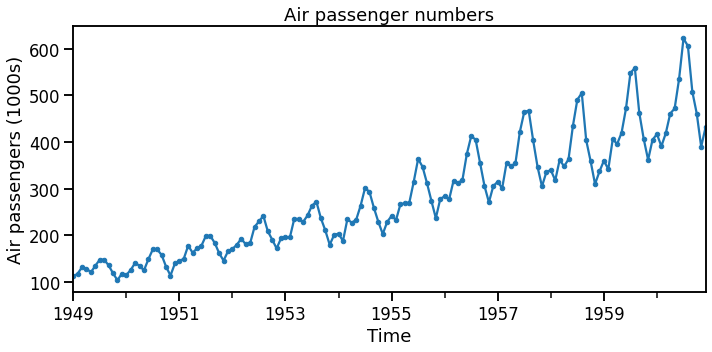

In [3]:
fig, ax = plt.subplots(figsize=[10, 5])
data.plot(y="y", marker=".", legend=None, ax=ax)
ax.set_xlabel("Time")
ax.set_ylabel("Air passengers (1000s)")
ax.set_title("Air passenger numbers")
plt.tight_layout()

# Let's build some forecasts with tree based models!

As the `TimeSince` transformer is new, to use it requires the development version of sktime. See instructions to install the development version [here](https://www.sktime.org/en/stable/installation.html#development-versions) or try pip installing straight from GitHub: `pip install git+https://github.com/sktime/sktime.git`.

 Let's build a recursive forecast and see how our trend feature can help!

In [4]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import HistGradientBoostingRegressor

In [5]:
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.series.time_since import TimeSince

In [6]:
# The data is monthly, let's work with pandas Period.
df = data.copy()
df.index = df.index.to_period("M")
df.head()

,y
ds,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


## Discussion on de-trending the data

Tree based models can work well when we de-trend the data and add it back to the forecast afterwards.

Let's use an sktime forecaster to model a polynomial trend:

$$T_t = \beta_0 + \beta_1t + \beta_2t^2 + ... + \beta_dt^d$$

where $d$ is the degree of the polynomial.

In [7]:
from sktime.forecasting.trend import PolynomialTrendForecaster

In [8]:
poly_trend = PolynomialTrendForecaster(degree=1)
trend = poly_trend.fit_predict(
                               y=df["y"], # Time series
                               fh=df["y"].index # Time periods to forecast
                              )

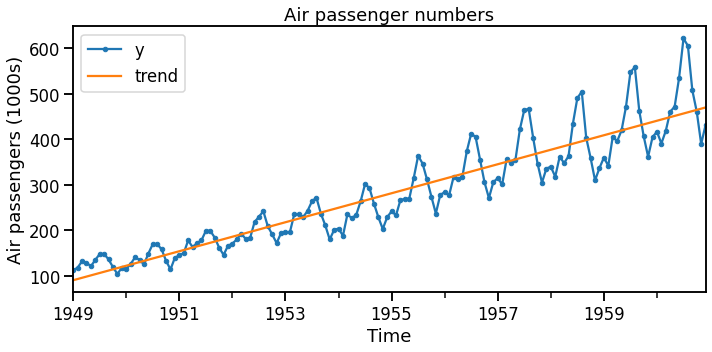

In [9]:
# Plot trend and time series
fig, ax = plt.subplots(figsize=[10, 5])
data.plot(y="y", marker=".", legend=None, ax=ax)
trend.plot(ax=ax)
ax.legend(["y", "trend"])
ax.set_xlabel("Time")
ax.set_ylabel("Air passengers (1000s)")
ax.set_title("Air passenger numbers")
plt.tight_layout()

The time series looks multiplicative. So to de-trend the data we will divide $y$ by the trend.

In [10]:
df["y_detrended"] = df["y"] / trend

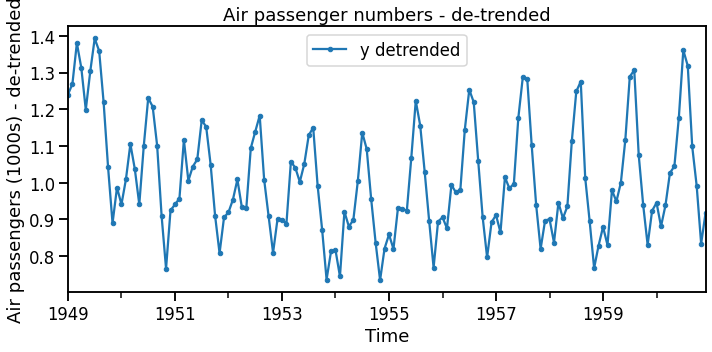

In [11]:
# Plot de-trended time series
fig, ax = plt.subplots(figsize=[10, 5])
df.plot(y="y_detrended", marker=".", legend=None, ax=ax)
ax.legend(["y detrended"])
ax.set_xlabel("Time")
ax.set_ylabel("Air passengers (1000s) - de-trended")
ax.set_title("Air passenger numbers - de-trended")
plt.tight_layout()

This will be a lot easier for a tree-based model to handle because the values that the tree needs to predict lie within the range of y values seen in the plot.

After forecasting the de-trended time series we will multiply back `trend`. 

## Recursive forecasting with de-trending in the workflow

We will augment our recursive forecasting workflow to take all of this into account. We now continue to build features as normal for the de-trended time series.

Prepare our transformers. 

We will still build the time feature. This is because it would still allow a tree based model to segment over time and isolate changepoints, outliers, and other interesting periods during training.

In [12]:
# Compute time feature for trend.
time_since_transformer = TimeSince()
time_since_transformer.fit_transform(df)

,time_since_1949-01
ds,
1949-01,0
1949-02,1
1949-03,2
1949-04,3
1949-05,4
...,...
1960-08,139
1960-09,140
1960-10,141


Let's create transformers that will build features from the target variable. This will always be in a separate pipeline because for recursive forecasting we need to re-compute these features on each forecast step.

In [13]:
# Features computed from the target.
# Compute lag and window features.
lag_window_transformer = WindowSummarizer(
    lag_feature={
        "lag": [1, 12],  # Lag features.
        "mean": [[1, 12]],  # [[lag, window size]]
    },
    truncate="bfill", # Backfill missing values from lagging and windowing.
    )

In [14]:
lag_window_transformer.fit_transform(df[["y_detrended"]])

,y_detrended_lag_1,y_detrended_lag_12,y_detrended_mean_1_12
ds,,,
1949-01,1.240173,1.240173,1.237239
1949-02,1.240173,1.240173,1.237239
1949-03,1.269266,1.240173,1.237239
1949-04,1.380402,1.240173,1.237239
1949-05,1.312556,1.240173,1.237239
...,...,...,...
1960-08,1.361046,1.306770,1.037692
1960-09,1.318370,1.075670,1.038659
1960-10,1.098816,0.939766,1.040588


Let's build a recursive forecast.

In [15]:
# --- CONFIG --- #
# Define time of first forecast, this determines our train / test split                                                    
forecast_start_period = pd.Period("1958", freq="M")
num_of_forecast_steps = 36

original_target = "y"
target = "y_detrended" # WE ARE FORECASTING THE DETRENDED SERIES.

# model = DecisionTreeRegressor(max_depth=10) # Model to forecast de-trended time series
model = HistGradientBoostingRegressor()
trend_model = PolynomialTrendForecaster(degree=1) # Model to describe trend

fit_once = True # if True fit model once.
                # if False fit model on each iteration.
    


# --- CREATE DYNAMIC TRAINING DATAFRAME  --- #
# `df_train` is "dynamic" because we will dynamically append 
# the features built from the target to this dataframe. 
# It's "training" because we use this dataframe 
# to create the training set passed to the model.
forecast_periods = pd.period_range(forecast_start_period, 
                                   periods=num_of_forecast_steps,
                                   freq="M")

# Ensure we only have training data up to the start
# of the forecast.
df_train = df.loc[:forecast_start_period].copy()

# Extend index to include the forecasting horizon.
# The target variable will be NaN in the forecasting horizon
# at this stage. As we iteratively make forecasts we will fill
# the missing values with forecasts.
df_train = pd.concat([
                      df_train,
                      pd.DataFrame(index=forecast_periods)
                     ], 
                     axis=1)

# --- DE-TREND THE TARGET VARIABLE ---#
# Train trend forecast during training period
trend_model.fit(y=df_train.loc[:forecast_start_period, original_target])
# Predict trend for both the train and forecast period
trend = trend_model.predict(fh=df_train.index)
# Create de-trended target variable
df_train[target] = df_train.loc[:, original_target] / trend

# --- FEATURE ENGINEERING FOR FUTURE KNOWN FEATURES --- #
# Here, we create any features where we already know 
# the feature value in the forecast horizon (i.e., the future).
# Hence, we can compute them just once and outside of the
# recursive forecasting loop that will follow.

# Create features from date and time.
X_time_features = time_since_transformer.fit_transform(df_train)


# --- RECURSIVE FORECASTING LOOP --- #
_model_is_not_fitted = True
for forecast_period in forecast_periods:    
    # --- FEATURE ENGINEERING FROM TARGET --- #
    # Create lag & window features.
    X_target_features = lag_window_transformer.fit_transform(df_train[[target]])

    # --- CREATE TRAIN AND TEST (PREDICT) SET --- #
    # Join the features onto the target, this  makes it easy to
    # inspect the features and target manually.
    df_y_and_X = pd.concat([
                            df_train[target], 
                            X_time_features, 
                            X_target_features,
                           ], axis=1)
    
    
    # Get feature names.
    features = df_y_and_X.columns.drop(labels=target)
    
    # Filter on forecast period to get training set.
    train_mask = df_y_and_X.index < forecast_period
    X_train = df_y_and_X.loc[train_mask, features]
    y_train = df_y_and_X.loc[train_mask, target]
    
    # Filter on forecast date to get test set (predict set). 
    # We're forecasting one step ahead at a time,
    # so there is only one row in X_test!
    X_test = df_y_and_X.loc[[forecast_period], features]

    # --- MAKE FORECAST --- #
    # Train a model. 
    #
    # If `fit_once` is True then the model
    # is trained only once, on the first
    # iteration, and then never again.
    #
    # If `fit_once` is False then the model 
    # is trained on the dyanmically expanding
    # training dataframe on each iteration.
    if fit_once and _model_is_not_fitted:
        model.fit(X_train, y_train)
        _model_is_not_fitted = False
    elif fit_once is False:
        model.fit(X_train, y_train)
    
    # Predict one step ahead. 
    y_pred = model.predict(X_test)
    
    # Append forecast to the target variable columnn in our
    # dynamic training dataframe `df_train`. This `df_train`
    # is ready for the next iteration where we will re-compute
    # features derived from the target.
    df_train.loc[forecast_period, target] = y_pred[0] 
    
# --- ADD TREND BACK --- #
df_train[original_target] = df_train[target] * trend

In [16]:
# --- CREATE IN-SAMPLE PREDICTIONS--- #
# Create predictions on the training set 
# using the one step ahead forecast model.
# Useful to plot when debugging models.
train_mask = df_y_and_X.index < forecast_start_period
X_train = df_y_and_X.loc[train_mask, features]

y_detrended_forecast_train = model.predict(X_train)
y_detrended_forecast_train = pd.DataFrame({target:y_detrended_forecast_train.flatten()}, index=X_train.index)

y_forecast_train = y_detrended_forecast_train[target] * trend

In [17]:
# --- CONVENIENT POST PROCESSING--- #
# Fill in last forecast in the dataframe that contains
# target and features.
df_y_and_X.loc[forecast_period, target] = y_pred[0]

# Retreive forecast and actuals
y_detrended_forecast = df_train.loc[forecast_start_period:, target]
y_detrended_train = df.loc[:forecast_start_period, target]
y_detrended_test = df.loc[forecast_start_period:, target]

y_forecast = df_train.loc[forecast_start_period:, original_target]
y_train = df.loc[:forecast_start_period, original_target]
y_test = df.loc[forecast_start_period:, original_target]

Text(0.5, 1.0, 'Air passenger numbers')

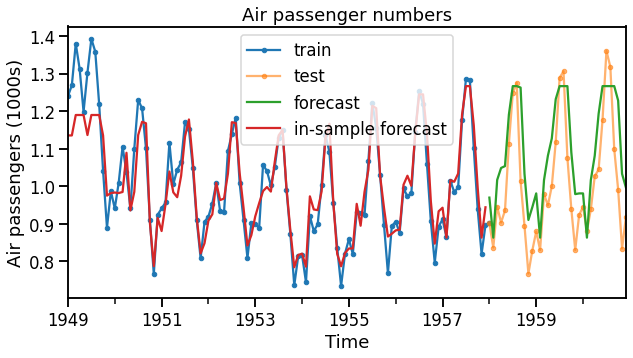

In [18]:
# --- PLOTTING Y DE-TRENDED --- #

# Plot the forecast.
fig, ax = plt.subplots(figsize=[10, 5])
# Plot training set.
y_detrended_train.loc[:forecast_start_period].plot(ax=ax, marker='.')
# Plot actuals in forecasting horizon.
y_detrended_test.plot(ax=ax, marker='.', alpha=0.6)
# Plot forecast.
y_detrended_forecast.plot(ax=ax)
# Plot 1 step forecasts in training data.
y_detrended_forecast_train.plot(ax=ax)

ax.legend(["train", "test", "forecast", "in-sample forecast"])
ax.set_xlabel("Time")
ax.set_ylabel("Air passengers (1000s)")
ax.set_title("Air passenger numbers")

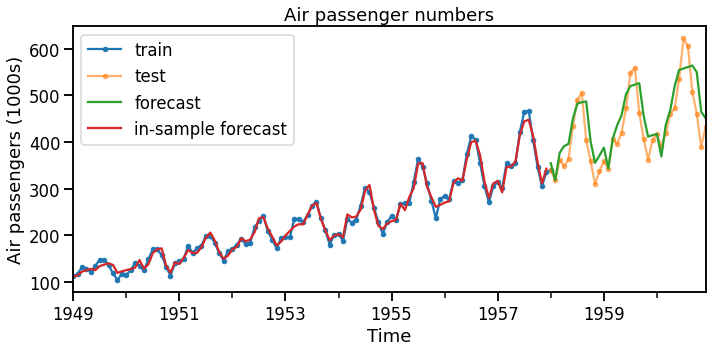

In [19]:
# --- PLOTTING Y--- #

# Plot the forecast.
fig, ax = plt.subplots(figsize=[10, 5])
# Plot training set.
y_train.loc[:forecast_start_period].plot(ax=ax, marker='.')
# Plot actuals in forecasting horizon.
y_test.plot(ax=ax, marker='.', alpha=0.6)
# Plot forecast.
y_forecast.plot(ax=ax)
# Plot 1 step forecasts in training data.
y_forecast_train.plot(ax=ax)

ax.legend(["train", "test", "forecast", "in-sample forecast"])
ax.set_xlabel("Time")
ax.set_ylabel("Air passengers (1000s)")
ax.set_title("Air passenger numbers")
plt.tight_layout()

Let's compute the RMSE of this forecast.

In [20]:
# Compute error metrics.
from sklearn.metrics import mean_squared_error
mean_squared_error(y_forecast, y_test.loc[y_forecast.index], squared=False)

40.303375847180014

We can now do recursive forecasting for tree-based models and adjusting for the trend!

Feel free to change the dates, try different models, and different features!